# Machine learning with time series data: Preparation
## Introduction

In this unit and the next one, we show an example of time series data and showcase the application of machine learning models for such data. In particular, we highlight some of the issues which are special to time series data and one should be mindful of them during the analysis and modeling of such data. Note that our objective is not to do a thorough analysis of time-series data but just to showcase how some of the machine learning models that you learned in this course can be applied to them. Therefore, we will skip most of the __Explanatory Data Analysis (EDA)__, which nevertheless is one of the main pillars of every machine learning project, in order to focus on our main goal. You can revisit course two and explore the methods for performing an EDA on data.

We use the data from the [Global Energy Forecasting Competition](https://en.wikipedia.org/wiki/Global_Energy_Forecasting_Competition) and develop a __regression__ problem to predict the one hour ahead electric load based on the hourly electric load and temperature data. Here is the outline of the steps we go through in this unit and we leave the next unit for developing the models:

- Loading the data
- Preliminary EDA
- Creating time features
- Creating lags
- Splitting the sample

Let's start by loading the data from the `c4_energy_data.csv` file provided in the resource tab. Before running the codes, ensure that you have activated the `adsml` environment.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.plotting import lag_plot
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# Load the data
df = pd.read_csv("c4_energy_data.csv", index_col=0, parse_dates=True)
print(df.shape)

(8760, 2)


In [3]:
df.head()

,load,temp
timestamp,,
2014-01-01 00:00:00,3295.0,-12.592593
2014-01-01 01:00:00,3173.0,-11.851852
2014-01-01 02:00:00,3085.0,-12.777778
2014-01-01 03:00:00,3053.0,-12.777778
2014-01-01 04:00:00,3077.0,-13.333333


We see that the data has a timestamp index with one-hour increments. The `load` shows the electric loads in Megawatt and the `temp` shows the temperatures in Celsius. There is a total of 8760 rows of data which as we later show in this unit is the number of hours from `2014-01-01 00:00:00` to `2014-12-31 23:00:00`. The data types as shown below are float and there is no null value in the data.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2014-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   load    8760 non-null   float64
 1   temp    8760 non-null   float64
dtypes: float64(2)
memory usage: 205.3 KB


      
> It is through the EDA that we learn about the data and decide about the data preprocessing strategies and machine learning modeling techniques. 
Here for brevity, we only show a quick tour of the data before jumping to the modeling part in the next unit.


## Preliminary Explanatory Data Analysis 

During the EDA one should explore the data in several ways. In particular, one should inspect (1) each individual feature, (2) the relation between the features, (3) the relation between the features and the target and finally investigate (4) how the interactions of two features can affect the target. However, in time-series data the time dimension has a centric role in the modeling and therefore one should expand the EDA and explore the dynamics of the features and the target over time (__trends and cycles__). Also, one should check how the target is correlated with its own values in the past (__temporal dependencies__). Finally, one should be mindful of the changes in the distribution of the data over time (__stationarity__). In the following, we do not cover all these steps and provide only a preliminary EDA and data preprocessing. You can revisit course two and explore methods that help build a solid understanding of the data.

To check if there is any missing hour in the sample we can generate date-time indexes and see if the length of these indexes is the same as the length of our data.

In [5]:
# generate date-time index with hourly frequency
datetime_idx = pd.date_range(min(df.index), max(df.index), freq="H")

print(datetime_idx.shape)

(8760,)


Since the length of the `datetime_idx` is the same as the length of our data we are sure that there is a data point available for each hour in the sample. But it is still likely that the hours are recorded irregularly. For instance, the time between two values is half an hour instead one hour. To check for this possibility we can have a look at unique hours.

In [6]:
df.index.hour.unique()

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23],
           dtype='int64', name='timestamp')

The result shows that values are registered regularly at each hour. Note that there can duplicated values in the data meaning that the temperature or the load don't change from one hour to the next. You can check this using the `duplicated()` function.

To get a sense of the distribution of the data we can quickly check the descriptive statistics and the histograms. 

In [7]:
# descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
load,8760.0,3329.719806,547.932788,2107.00000,2911.000000,3387.000000,3721.250000,5036.00000
temp,8760.0,8.080395,11.160144,-25.37037,-0.185185,8.888889,17.037037,30.37037


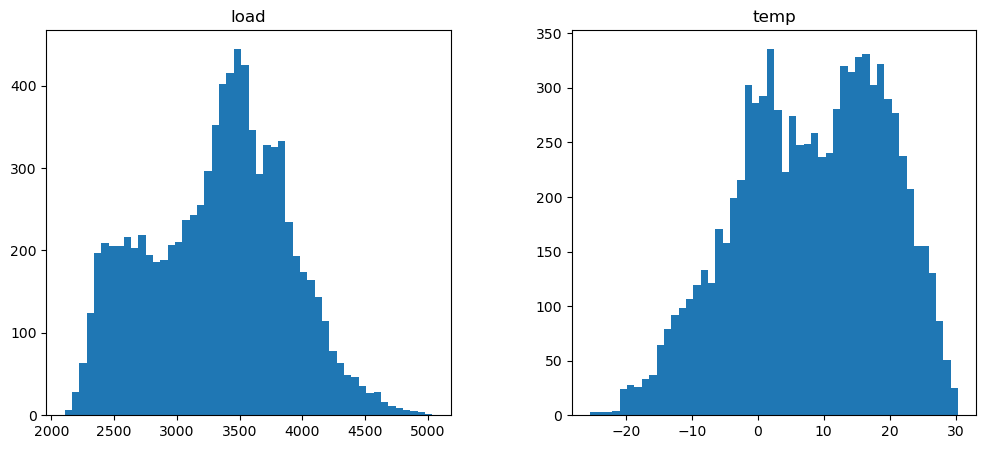

In [8]:
# plot histograms
df[["load", "temp"]].hist(figsize=(12, 5), bins=50, grid=False)
plt.show()

According to the descriptive statistics and the histograms the data contain no extreme observation and the distributions look fairly symmetric.

To get a quick sense of the trends and cycles in the data we can plot them against time.

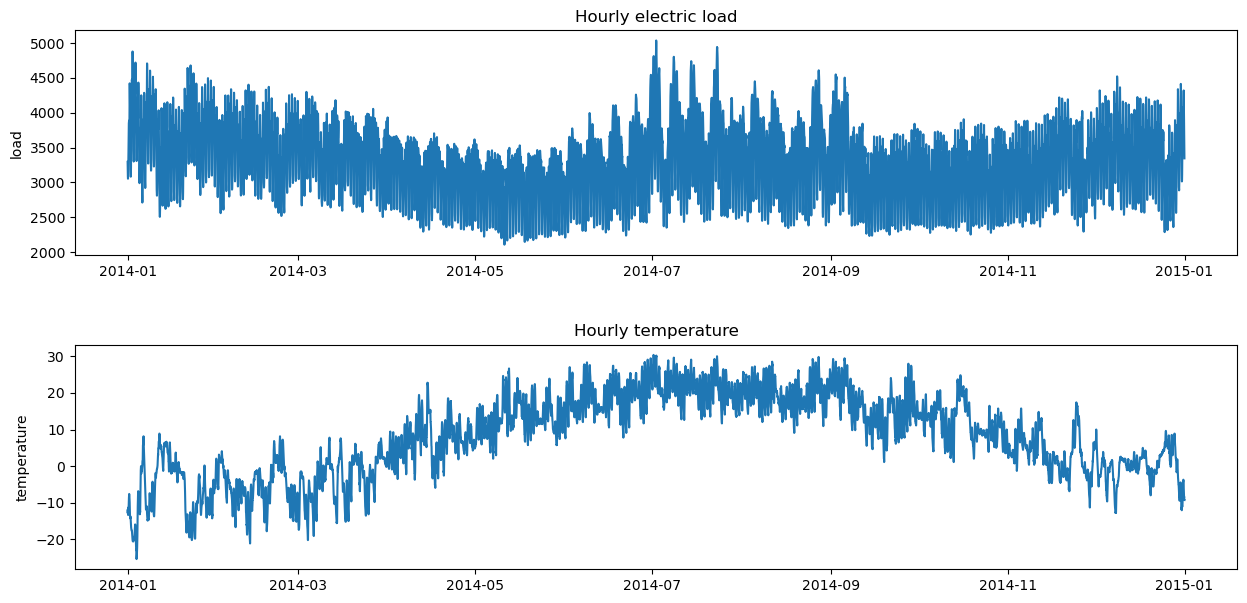

In [9]:
# SKIP-INPUT

# plotting trend and seasonality
fig, ax = plt.subplots(2, 1, figsize=(15, 7), gridspec_kw={"hspace": 0.4})

ax[0].plot(df["load"])
ax[0].set_title("Hourly electric load")
ax[0].set_ylabel("load")

ax[1].plot(df["temp"])
ax[1].set_title("Hourly temperature")
ax[1].set_ylabel("temperature")

plt.show()

As expected, both electric load and temperature time-series show seasonal trends meaning that there are regular repetitions of patterns over time. Therefore, in general, the time could provide a basis for our expectation of the electric load. For instance, the first plot shows that the load is higher at the beginning, middle, and end of the year when the weather is either too cold or too hot. It is also likely that the *day of the week* and *the hour* matter for the load demand. 
So, let's benefit from the time index of the data and create features that represent the time.


        
> Some time-series processes are not stationary in the sense that their distributions vary over time. 
One can use [statistical tests of stationarity](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) or visually assess this behavior. 
Differencing and log-transformation are two approaches to fight non-stationarity and to stabilize the mean and variance of the time series processes. 
The load and temperature data do not show a strong violation of stationarity as the data vary within a certain range and don't exhibit exploding trends.


In [10]:
# create time features
df["month"] = df.index.month - 1
df["day"] = df.index.day_of_week
df["hour"] = df.index.hour

df.head()

,load,temp,month,day,hour
timestamp,,,,,
2014-01-01 00:00:00,3295.0,-12.592593,0,2,0
2014-01-01 01:00:00,3173.0,-11.851852,0,2,1
2014-01-01 02:00:00,3085.0,-12.777778,0,2,2
2014-01-01 03:00:00,3053.0,-12.777778,0,2,3
2014-01-01 04:00:00,3077.0,-13.333333,0,2,4


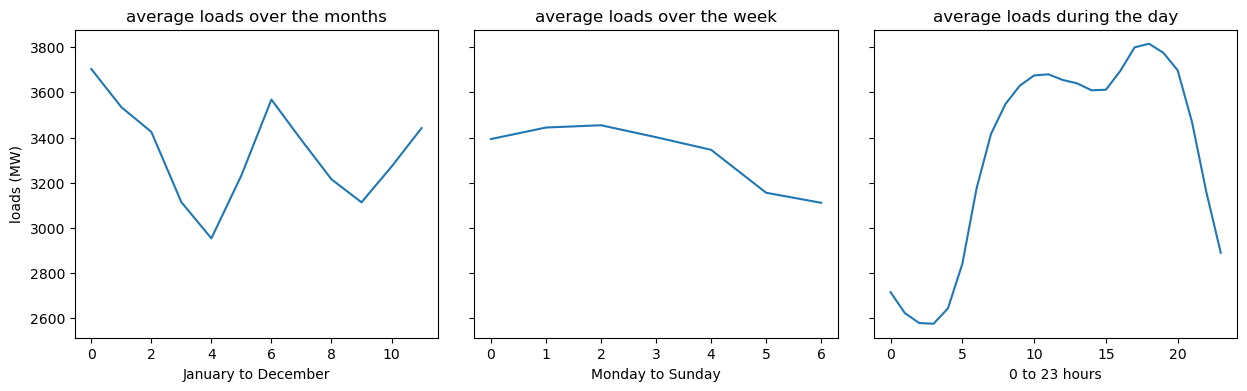

In [11]:
# SKIP-INPUT
fig, ax = plt.subplots(
    nrows=1, ncols=3, figsize=(15, 4), sharey=True, gridspec_kw={"wspace": 0.1}
)

ax[0].plot(df.groupby("month").mean()["load"])
ax[1].plot(df.groupby("day").mean()["load"])
ax[2].plot(df.groupby("hour").mean()["load"])

ax[0].set_title("average loads over the months")
ax[1].set_title("average loads over the week")
ax[2].set_title("average loads during the day")

ax[0].set_xlabel("January to December")
ax[1].set_xlabel("Monday to Sunday")
ax[2].set_xlabel("0 to 23 hours")

ax[0].set_ylabel("loads (MW)")

plt.show()

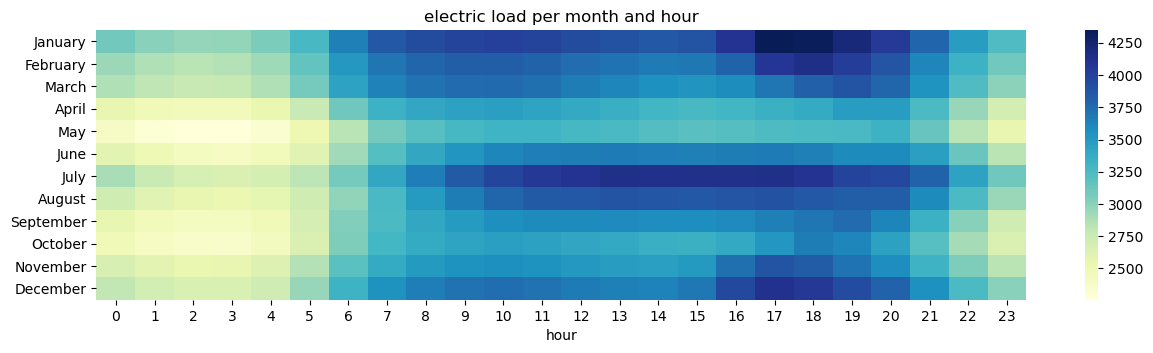

In [12]:
# SKIP-INPUT

# heatmap
df1 = df.groupby(["month", "hour"], sort=False).agg(["mean"])
df1.columns = df1.columns.droplevel(1)
df1.reset_index(inplace=True)

fig, axes = plt.subplots(figsize=(15, 3.5))

heatmap = pd.pivot_table(df1, values="load", index="month", columns="hour")
heatmap.index = df.index.month_name().unique().tolist()
sns.heatmap(heatmap, cmap="YlGnBu")
axes.set_title("electric load per month and hour")

plt.show()

The plots in the first row show that the load demand is higher in January, July and December (compared to other months), during the weekdays (compared to the weekends) and during the daytime (compared to the nights). Therefore, it makes sense to keep these features and use them in our models. Note that the interactions of time features could also matter for the electric load. The heatmap shows that demand for the electric load during the daytime depends on the month, whereas from 1 am to 5 am the month doesn't matter much.

Next, we create two features that can play a big role in predicting the load. One simple conjecture is that the past values of the load and temperature can predict load demand. Our data has an hourly frequency and our objective is to predict the load one hour ahead. Therefore, we create lags of the load and temperature.

In [13]:
# 1 hour lags
df["load_lag1"] = df["load"].shift(1)
df["temp_lag1"] = df["temp"].shift(1)

#  dropping the rows with na
df.dropna(how="any", inplace=True)

# we don't need the temp anymore
df.drop(["temp"], axis=1, inplace=True)

df.head()

,load,month,day,hour,load_lag1,temp_lag1
timestamp,,,,,,
2014-01-01 01:00:00,3173.0,0,2,1,3295.0,-12.592593
2014-01-01 02:00:00,3085.0,0,2,2,3173.0,-11.851852
2014-01-01 03:00:00,3053.0,0,2,3,3085.0,-12.777778
2014-01-01 04:00:00,3077.0,0,2,4,3053.0,-12.777778
2014-01-01 05:00:00,3171.0,0,2,5,3077.0,-13.333333


Now let's visualize the relationship between the lagged temperature and load that we just created and the current load values.

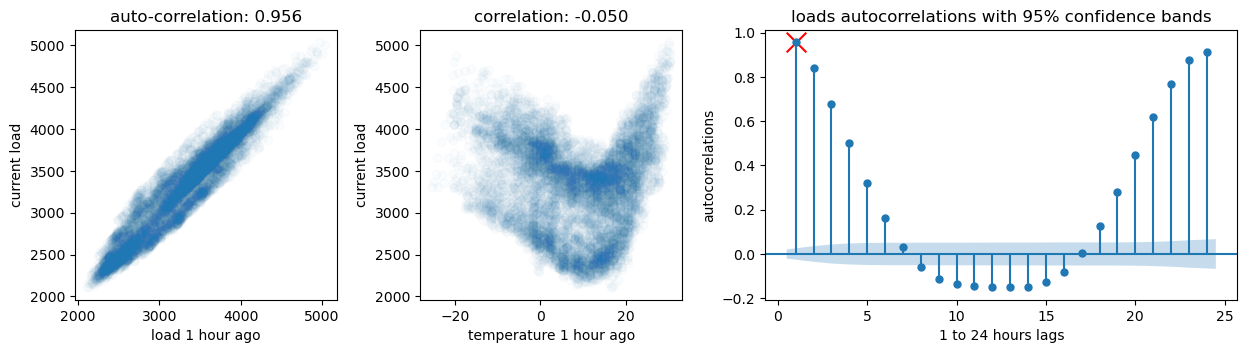

In [14]:
# SKIP-INPUT
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(15, 3.5),
    gridspec_kw={"wspace": 0.25, "width_ratios": [1, 1, 1.8]},
)

# scatter plots of the values with their first lags
lag_plot(df["load"], lag=1, ax=axes[0], alpha=0.02)
axes[1].scatter(df["temp_lag1"], df["load"], alpha=0.02)

axes[0].set(
    xlabel="load 1 hour ago",
    ylabel="current load",
    title=r"auto-correlation: {:.3f}".format(df["load"].squeeze().autocorr(1)),
)
axes[1].set(
    xlabel="temperature 1 hour ago",
    ylabel="current load",
    title=r"correlation: {:.3f}".format(df["load"].corr(df["temp_lag1"])),
)

#  plot autocorrelations
sm.graphics.tsa.plot_acf(df["load"], lags=24, alpha=0.05, zero=False, ax=axes[2])
# axes[2].grid()
axes[2].set(
    xlabel="1 to 24 hours lags",
    ylabel="autocorrelations",
    title="loads autocorrelations with 95% confidence bands",
)
# red marker for the 1st lag
axes[2].scatter(1, df["load"].squeeze().autocorr(1), marker="x", c="red", s=50 * 2 ** 2)

plt.show()

From the plots, it seems that the load one hour in the past is a potential predictor of the load. Also, the nature of the relation between the temperature and the load is not linear and finally, the auto-correlation plot on the right shows that the load is auto-correlated with many lagged loads.



> Using only the 1st lag is a simple strategy that doesn't lead necessarily to the best prediction. 
The EDA can help to gain insight into the temporal dependencies in the data. 
In particular, one should motivate the choice of lagged features based on auto-correlations in the data, and then decide how many lags are needed. One can decide about the number of lags based on certain [statistical tests](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html), or even tune it as a parameter using the validation set.



## Sample split
We use the last month of the sample, i.e. December, for testing and the rest of the data, that is January to November for __training and validations__. For simplicity, we don't use the rolling windows or expanding windows strategies for splitting time series data as discussed in the previous course. The following plot shows how the training, validation and test sets are placed ahead of each other over time.

In [15]:
# Split into train/test sets
train = df.loc["2014-01-01":"2014-10-30"]  # 10 months
valid = df.loc["2014-11-01":"2014-11-30"]  # 1 month
test = df.loc["2014-12-01":"2014-12-31"]  # 1 month

print("Train:", train.shape)
print("Validation: ", valid.shape)
print("Test: ", test.shape)

Train: (7271, 6)
Validation:  (720, 6)
Test:  (744, 6)


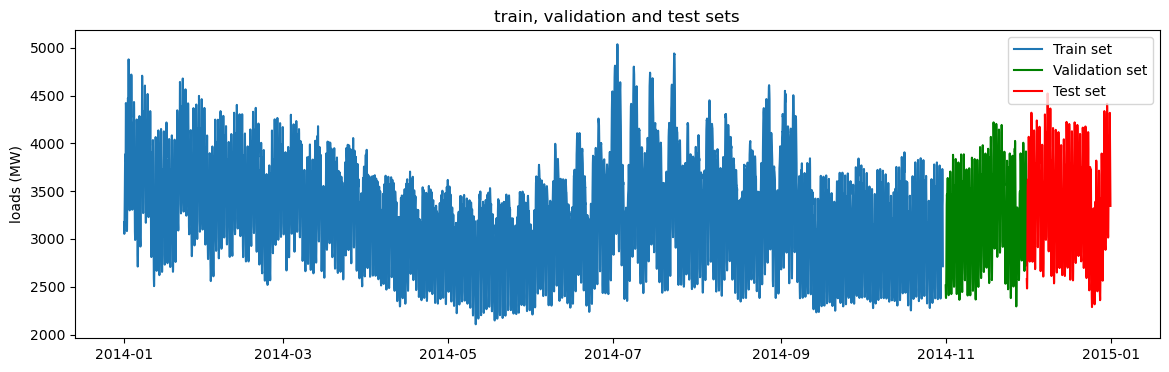

In [16]:
# Plot training and test sets
fig = plt.figure(figsize=(14, 4))
plt.plot(train.load, label="Train set")
plt.plot(valid.load, label="Validation set", color="g")
plt.plot(test.load, label="Test set", color="r")

plt.title("train, validation and test sets")
plt.ylabel("loads (MW)")
plt.legend()
plt.show()

However, since we intend to perform grid search cross-validation, we don't use a fixed validation set as shown above (in green). We rather let the validation set iterate between January to November. To do this we use the `TimeSeriesSplit` cross-validator object as shown in the following example with 5 splits.

In [17]:
# SKIP

import random
import numpy as np

np.random.seed(0)
random.seed(0)

In [18]:
#  load the library
from sklearn.model_selection import TimeSeriesSplit

# Split data into train/test sets
train = df.loc["2014-01-01":"2014-11-30"]  # 11 months
test = df.loc["2014-12-01":"2014-12-31"]  # 1 month

# Split train set into train/validation sets
cv = TimeSeriesSplit(n_splits=5, test_size=24 * 30 * 1)  #  1 month of validation set



> Note that here the `test_size` in the `TimeSeriesSplit` object refers to the size of the validation data, which we set to 1 month.


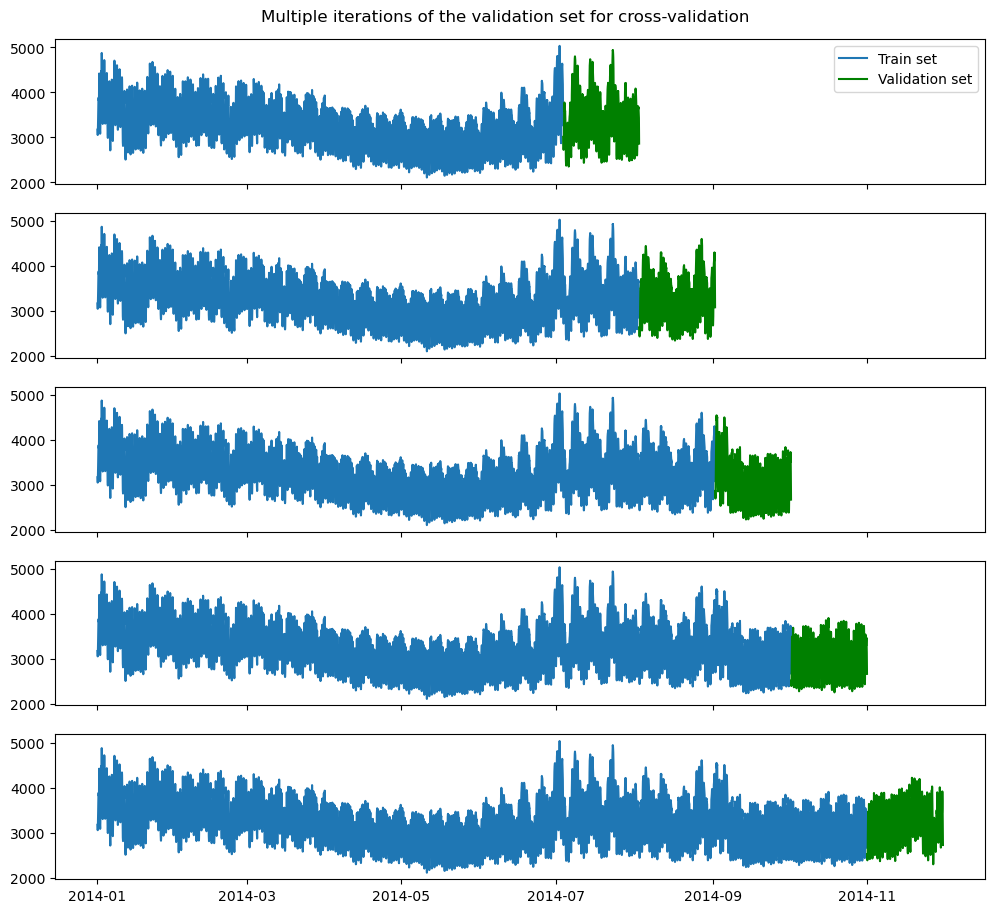

In [19]:
# Plot iterations of the training and validation sets
fig, axes = plt.subplots(5, 1, figsize=(12, 10), sharex=True, sharey=True)
plt.suptitle("Multiple iterations of the validation set for cross-validation")

for (i, (tr, val)), ax in zip(enumerate(cv.split(train.load)), axes.ravel()):

    # Plot training and validation sets
    ax.plot(train["load"][tr], label="Train set")
    ax.plot(train["load"][val], label="Validation set", color="g")

axes[0].legend()
plt.subplots_adjust(top=0.95)
plt.show()



> Unlike the standard cross-validation objects (e.g. KFold) the `TimeSeriesSplit` makes sure that the validation sets come always after the training set.


In the next unit, we show how to use this cross-validator object for the grid search. For now, let's save the train and test sets for the next unit where we use them to train and test two machine learning models.

In [20]:
# save the data into csv files
train.to_csv("c4_ts_train.csv")
test.to_csv("c4_ts_test.csv")

## Summary

Here is a quick summary of what we did in this unit:

- We showed a quick EDA of the data and highlighted that the EDA for time series data requires doing additional steps.
- Time series data could show auto-correlations over time and therefore we need to create lags of the target and features.
- The sample split and cross-validation are different for time series data.